# ∆pCO2 SEACOW Analysis Script
- Read in ∆pCO2 data
- Plot time-series
- Average air and water-side CO2 values
- Plot averages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import scipy

import warnings
warnings.filterwarnings('ignore')

In [18]:
#filename = '2022_10_06_DockDeployment'
filename = 'OctoberSEACOW4C'

filepath = os.path.join('Data', filename+'.csv')
df = pd.read_csv(filepath, header = 0, parse_dates = [11])
df = df.drop(columns = ['ID','VaporPressure','K30H2O'])
df.tail()

,Real_Time,Elapsed_Time,CO2_ppm,State,Bat_Percent,BAT_V,WaterTemp_C,InsideTemp_C,Pressure_Pa,Humidity_Percent,AirTemp_C,Datetime
264998,946961680,276880.996,361.731571,water,51.93,3.84,17.81,21.31,101491.35,44.75,19.9,2023-10-08 14:25:24
264999,946961683,276883.081,360.805716,water,51.93,3.84,17.81,21.31,101480.92,44.73,19.9,2023-10-08 14:25:27
265000,946961685,276885.165,360.784499,water,51.93,3.84,17.81,21.31,101494.83,44.76,19.9,2023-10-08 14:25:29
265001,946961687,276887.250,360.777427,water,51.93,3.84,17.81,21.31,101504.83,44.77,19.9,2023-10-08 14:25:31
265002,946961689,276889.485,360.805716,water,51.93,3.84,17.81,21.31,101507.00,44.73,19.9,2023-10-08 14:25:33


## Break down into air-side and water-side measurements
- `State` column contains "air" or "water" indicating measurement side

In [19]:
air_or_water = df.loc[:, 'State']
df_one = pd.get_dummies(df['State']) # separate binary vals into columns
switch_ind = df_one['air'].diff() # find rows where it switches
switch_ind_shift = switch_ind[1:] # shift by one
switch_ind_shift[len(switch_ind-1)] = 1 # add a one at end
switches = switch_ind_shift[switch_ind_shift != 0] # get non-zero rows
switch_i = switches.index # get index of non-zero rows
air_mask = air_or_water=='air'
switch_i

Int64Index([  1797,   2037,   3836,   4076,   5875,   6115,   7914,   8154,
              9953,  10193,
            ...
            255257, 257057, 257297, 259097, 259337, 261137, 261377, 263177,
            263417, 265003],
           dtype='int64', length=259)

## Get CO2 values, separate into air and water-side

In [20]:
# Get CO2 
CO2 = df.loc[:, 'CO2_ppm']

# Apply mask to select CO2 readings on air or water side
CO2_air = CO2[air_mask]
CO2_water = CO2[~air_mask]

## Get time, separate into air and water-side

In [21]:
# Select elapsed time (in milliseconds) column and break into air/water sections
etime_sec = df.loc[:, 'Elapsed_Time'].astype(int)

In [22]:
# etime_ms_list = etime_ms.tolist()
# for i, e in enumerate(etime_ms_list):
#     if i == len(etime_ms_list)-1:
#         print(i)
#     else:
#         if etime_ms[i+1]<etime_ms[i]:
#             etime_ms[i+1] += etime_ms[i]
        
df.loc[:, 'Elapsed_Time'] = etime_sec

In [23]:
etime_hr = etime_sec/60/60
etime_hr_air = etime_hr[air_mask]
etime_hr_water = etime_hr[~air_mask]

In [24]:
Datetimeair = df.Datetime[air_mask]
Datetimewater = df.Datetime[~air_mask]

## Plot "raw" time-series

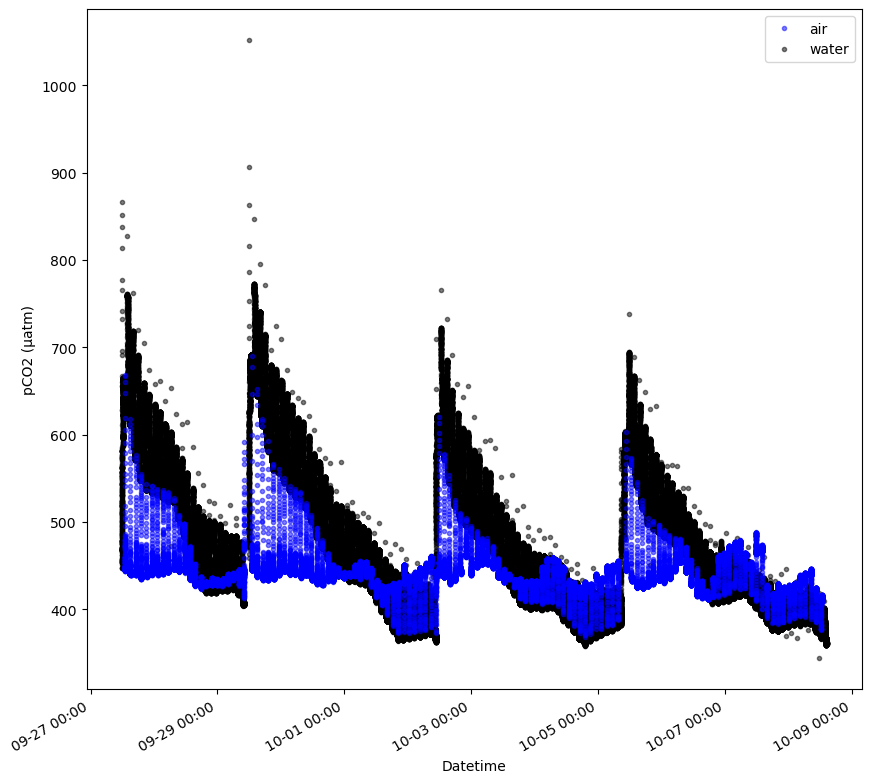

In [25]:
#%% Plot CO2 vs. time from raw data
fig, axs = plt.subplots(figsize = (10, 10))
axs.plot(Datetimeair, CO2_air, 'b.', alpha = 0.5, label = 'air')
axs.plot(Datetimewater, CO2_water, 'k.', alpha = 0.5, label = 'water', zorder = 1)

axs.set_ylabel('pCO2 (µatm)')
axs.set_xlabel('Datetime')

axs.legend(loc = "best")

fig.autofmt_xdate()
# Define the date format
date_form = DateFormatter("%m-%d %H:%M")
axs.xaxis.set_major_formatter(date_form)

fig_fn = 'RawTimeSeries_'+filename
fig_file = os.path.join('Figures', fig_fn+'.png')
plt.savefig(fig_file, dpi = 500, transparent=False)

## Function to calculate tau and p2
`p(t) = (p2-p1)*(1-e^(-t/Tau))+p1`
- p1 is starting pCO2
- p2 is estimated endpoint
- tau we hope we know from lab work
- t is elapsed time

In [82]:
# first-order response function to fit
def FOR(t, p2):
    return (p2-p1)*(1-np.exp(-t/tau))+p1

def get_p2_and_tau(etime_hr_input, CO2_input):
    t = etime_hr_input-etime_hr_input[0]
    y = CO2_input

    popt, pcov = scipy.optimize.curve_fit(FOR, t, y)

    p2 = popt
    
    # print("p2 is {}; tau is {}".format(p2, tau))
    
    return p2

## Process separated air and water-side values

In [83]:
# Create df of averages before switches
n_before = 15 # samples before switch to average (f ~ 0.5 Hz)
df_averages = pd.DataFrame(columns = df.columns, index = np.linspace(0, len(switch_i)-1, len(switch_i))) # instantiate df to fill

# In averaging below, columns with strings get messed up, so put them at end of dataFrame now
cols = list(df_averages.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('State')) #Remove x from list
df_averages = df_averages[cols+['State']] #Create new dataframe with columns in the order you want

pad = 10 # give it a few seconds to make the switch
i_start = pad
for m, i in enumerate(switch_i):
    df_small = df.iloc[i_start:i, :].reset_index() # switch occurs at ith value, so since python indexing doesn't include upper value in range, this stops one short
    air_or_water = df_small['State'][0]
    
    if air_or_water == 'air':
        tau = 0.0006
    else:
        tau = .45
        
    
    CO2_small = df_small['CO2_ppm']
    p1 = np.nanmean(CO2_small[0]) # starting pCO2
    e_time_small = df_small['Elapsed_Time']
    e_time_hr_small = e_time_small/60/60
    
    # p2, tau = get_p2_and_tau(e_time_hr_small, CO2_small)
    p2 = get_p2_and_tau(e_time_hr_small, CO2_small)
    
    # Get averages of everything
    df_small_ave = df_small.mean()
    
    # Replace avg CO2 with extrapolated endpoint
    df_small_ave['CO2_ppm'] = p2
    
    # reset time to end time rather than avg
    df_small_ave['Elapsed_Time'] = e_time_small.iloc[-1]
    df_small_ave['Datetime'] = df_small['Datetime'].iloc[-1]
    df_small_ave['Real_Time'] = df_small['Real_Time'].iloc[-1]
    # Add state to list
    df_small_ave['State'] = air_or_water
    
    # Get rid of index avg
    df_small_ave.drop('index', inplace = True)
    
    df_averages.iloc[m, :] = df_small_ave
    
    i_start = i+pad # redefine for next loop

    #print(df_small_ave, m)

In [84]:
df_averages2 = df_averages.set_axis(['Real_Time','Elapsed_Time', 'CO2_ppm', 'Bat_Percent', 'BAT_V', 'WaterTemp_C', 
                                    'InsideTemp_C', 'Pressure_Pa', 'Humidity_Percent','AirTemp_C', 'Datetime',
                                    'State', ], 
                                    axis=1)#, copy=False)
df_averages2.to_csv('Modeled'+filename+'.csv')

df_averages2.head()

,Real_Time,Elapsed_Time,CO2_ppm,Bat_Percent,BAT_V,WaterTemp_C,InsideTemp_C,Pressure_Pa,Humidity_Percent,AirTemp_C,Datetime,State
0.0,946688573,3773.0,717.760065,98.976486,4.173274,21.437252,24.143816,102408.562647,43.490235,23.56826,2023-09-27 12:56:50,water
1.0,946689078,4278.0,455.072322,97.978348,4.16287,21.373957,24.69413,102350.201913,45.391435,23.831826,2023-09-27 13:05:15,air
2.0,946695962,11162.0,590.928492,97.031492,4.157881,21.442627,24.121587,102145.968681,44.677043,23.944796,2023-09-27 14:59:59,water
3.0,946696467,11667.0,449.268106,96.156957,4.15,21.469957,24.666565,102211.849609,45.648652,23.994565,2023-09-27 15:08:24,air
4.0,946703352,18552.0,558.848135,95.405103,4.144589,21.527775,24.172901,102011.814153,44.801973,24.013354,2023-09-27 17:03:09,water


## Separate air and water-side stuff in new, small averaged DF 

In [85]:
# Get CO2 and mask for air or water for averaged sections
air_or_water_sm = df_averages2.loc[:, 'State']
air_mask_sm = air_or_water_sm=='air'

# Manage time
etime_sm_sec = df_averages2.loc[:, 'Elapsed_Time'].astype(int)
etime_sm_hr = etime_sm_sec/60/60
time_start_sec = etime_sm_sec.iloc[0]
time_end_sec = etime_sm_sec.iloc[-1]
time_total_sec = time_end_sec-time_start_sec
time_total_hr = time_total_sec/60/60

CO2_sm = df_averages2.loc[:, 'CO2_ppm']
CO2_sm_air = CO2_sm[air_mask_sm]
CO2_sm_water = CO2_sm[~air_mask_sm]
etime_sm_hr_air = etime_sm_hr[air_mask_sm]
etime_sm_hr_water = etime_sm_hr[~air_mask_sm]

dt_all = df_averages2.loc[:, 'Datetime']
dt_air = dt_all[air_mask_sm]
dt_water = dt_all[~air_mask_sm]

CO2_sm

0.0      717.760065
1.0      455.072322
2.0      590.928492
3.0      449.268106
4.0      558.848135
            ...    
254.0    372.888288
255.0    421.516006
256.0    362.163909
257.0    411.303963
258.0    355.372694
Name: CO2_ppm, Length: 259, dtype: object

## Plot raw (individual K30 readings) plus averages

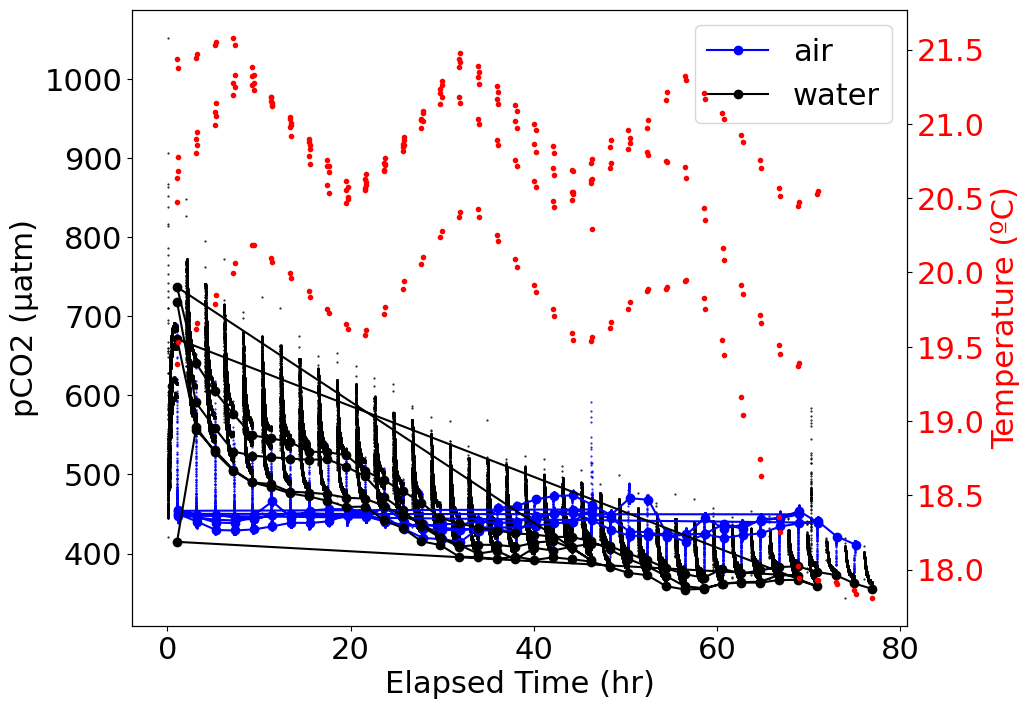

In [86]:
#%% Plot Raw + Averages
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(figsize = (10, 8))
ax2 = axs.twinx()

# Raw data
axs.plot(etime_hr_air, CO2_air, 'b.', markersize = 1, label = None)#'air')
axs.plot(etime_hr_water, CO2_water, 'k.', markersize = 1, label = None)#'water')

# Averaged data
axs.plot(etime_sm_hr_air, CO2_sm_air, 'bo-', label = 'air')
axs.plot(etime_sm_hr_water, CO2_sm_water, 'ko-', label = 'water')

axs.set_ylabel('pCO2 (µatm)')
axs.set_xlabel('Elapsed Time (hr)')
# axs.set_ylim([400, 1200])

# Add temperature
color2 = 'red'
ax2.plot(etime_sm_hr, df_averages.loc[:, 'WaterTemp_C'], '.', color = color2)
ax2.set_ylabel('Temperature (ºC)', color=color2)  
ax2.tick_params(axis='y', labelcolor=color2)

axs.legend(loc = "best")
#fig_fn = 'fig_rawprojected_'+filename
#fig_file = os.path.join('Figures', fig_fn+'.png')
#plt.tight_layout()
#plt.savefig(fig_file, dpi = 300)

## Modeled results only (no raw data)

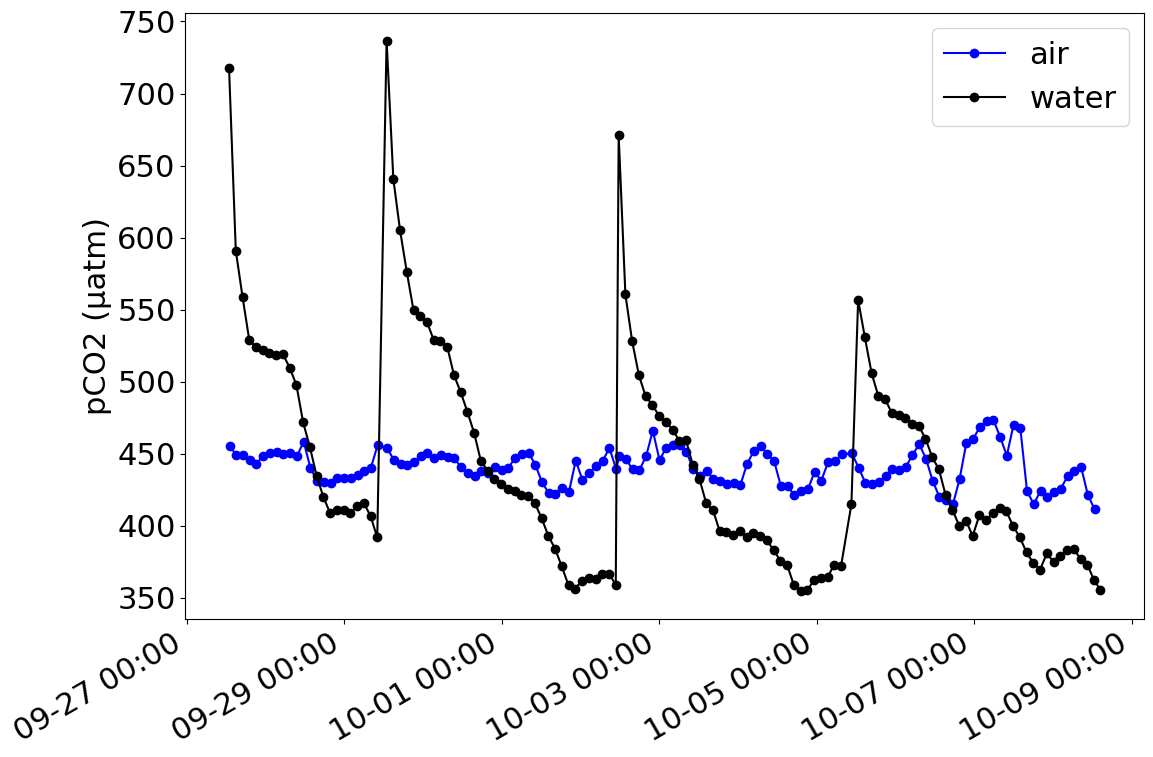

In [87]:
#%% Plot Raw + Averages
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(figsize = (12, 8))
#ax2 = axs.twinx()

# Averaged data
axs.plot(dt_air, CO2_sm_air, 'bo-', label = 'air')
axs.plot(dt_water, CO2_sm_water, 'ko-', label = 'water')

axs.set_ylabel('pCO2 (µatm)')
# axs.set_xlabel('Elapsed Time (hr)')
# axs.set_ylim([400, 1200])
# Add temperature
color2 = 'gray'
# ax2.plot(df_averages2.loc[:, 'Datetime'], df_averages2.loc[:, 'WaterTemp_C'], 'o', color = color2)
# ax2.set_ylabel('Temperature (ºC)', color=color2)  
# ax2.tick_params(axis='y', labelcolor=color2)
#ax2.plot(cormp['time'], cormp['wl_meters'], '.', markersize = 2, color = color2)
#ax2.set_ylabel('Water Level (m, NAVD88)', color=color2)  
#ax2.tick_params(axis='y', labelcolor=color2)

axs.legend(loc = "best")

fig.autofmt_xdate()
# Define the date format
date_form = DateFormatter("%m-%d %H:%M")
axs.xaxis.set_major_formatter(date_form)
plt.tight_layout()

fig_fn = 'fig_projected_'+filename
fig_file = os.path.join('Figures', fig_fn+'.png')
plt.savefig(fig_file, dpi = 500, transparent=False)

In [33]:
##Saving each one in its own thang
SEACOW1air = pd.DataFrame(data=list(zip(dt_air, CO2_sm_air)),columns=['Datetime','CO2_ppm'])
SEACOW1water = pd.DataFrame(data=list(zip(dt_water, CO2_sm_water)),columns=['Datetime','CO2_ppm'])
SEACOW1delta = SEACOW1air.copy()
SEACOW1delta['CO2_ppm'] = SEACOW1water['CO2_ppm'] - SEACOW1air['CO2_ppm']
SEACOW1delta.head()

,Datetime,CO2_ppm
0,2023-09-27 13:05:52,74.758846
1,2023-09-27 15:09:00,38.549547
2,2023-09-27 17:12:09,23.700080
3,2023-09-27 19:15:17,9.194908
4,2023-09-27 21:18:26,12.234892


In [73]:
SEACOW3air = pd.DataFrame(data=list(zip(dt_air, CO2_sm_air)),columns=['Datetime','CO2_ppm'])
SEACOW3water = pd.DataFrame(data=list(zip(dt_water, CO2_sm_water)),columns=['Datetime','CO2_ppm'])
SEACOW3delta = SEACOW3air.copy()
SEACOW3delta['CO2_ppm'] = SEACOW3water['CO2_ppm'] - SEACOW3air['CO2_ppm']
SEACOW3delta.head()

,Datetime,CO2_ppm
0,2023-09-27 13:00:37,150.572237
1,2023-09-27 15:03:46,80.237483
2,2023-09-27 17:06:54,43.965042
3,2023-09-27 19:10:02,26.163258
4,2023-09-27 21:13:11,34.015692


In [88]:
SEACOW4air = pd.DataFrame(data=list(zip(dt_air, CO2_sm_air)),columns=['Datetime','CO2_ppm'])
SEACOW4water = pd.DataFrame(data=list(zip(dt_water, CO2_sm_water)),columns=['Datetime','CO2_ppm'])
SEACOW4delta = SEACOW4air.copy()
SEACOW4delta['CO2_ppm'] = SEACOW4water['CO2_ppm'] - SEACOW4air['CO2_ppm']
SEACOW4delta.head()

,Datetime,CO2_ppm
0,2023-09-27 13:05:15,262.687743
1,2023-09-27 15:08:24,141.660386
2,2023-09-27 17:11:33,109.923780
3,2023-09-27 19:14:42,83.110113
4,2023-09-27 21:17:51,80.772127


In [33]:
#Okay so now I have three delta data frames, so I want to plot them all three on same thing with DO. So I should load in DO

filepath = os.path.join('Data', 'OctoberDO1.csv')
DO1 = pd.read_csv(filepath, header = 0, parse_dates = [0])
#DO1.head()

filepath = os.path.join('Data', 'OctoberDO2.csv')
DO2 = pd.read_csv(filepath, header = 0, parse_dates = [0])
DO2.head()


,Datetime,BV..Volts.,T..deg.C.,DO..mg.l.,Q...,UTC_Date_._Time,EasternTime,Battery,Temperature,Dissolved.Oxygen.Saturation,Q
0,2023-09-27 12:03:00,3.41,22.912,8.679,0.899,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-09-27 12:05:00,3.41,22.393,8.972,0.899,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-09-27 12:07:00,3.41,22.050,9.014,0.896,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-09-27 12:09:00,3.41,21.840,9.116,0.898,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-09-27 12:11:00,3.41,21.706,9.125,0.896,NaN,NaN,NaN,NaN,NaN,NaN


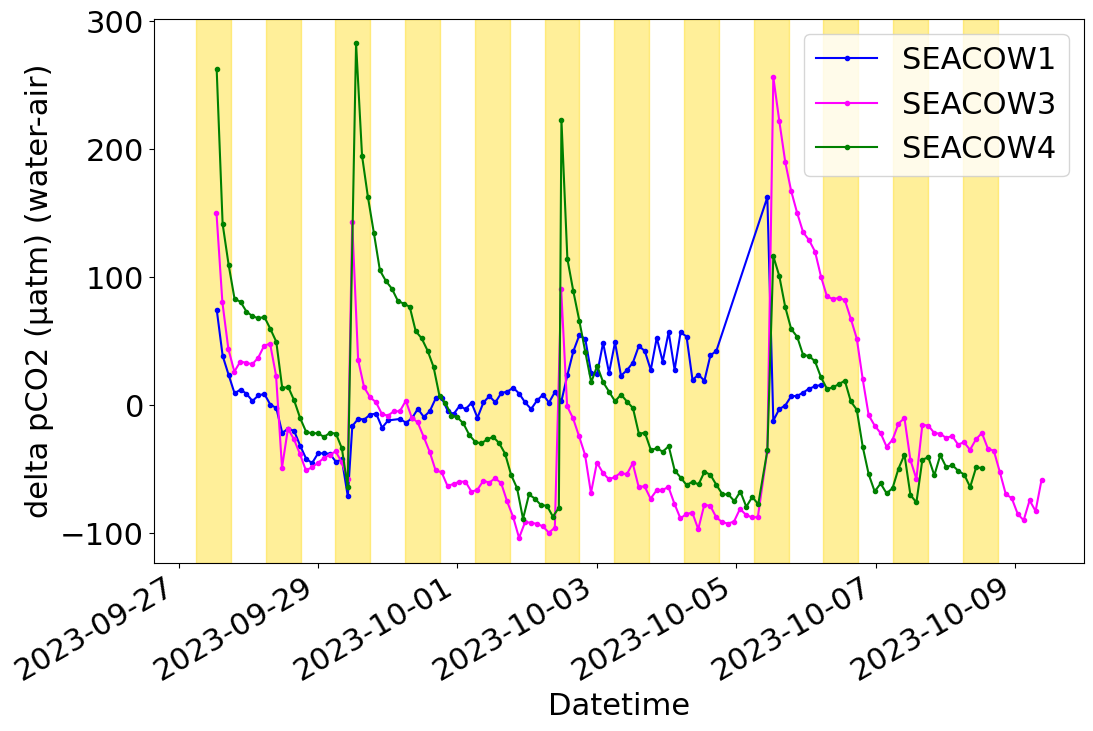

In [91]:
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(figsize = (12, 8))

SEACOW1delta.plot(ax=ax1, x='Datetime', y='CO2_ppm',marker = '.', color="blue", label = 'SEACOW1',figsize=(12,8) )
SEACOW3delta.plot(ax=ax1, x='Datetime', y='CO2_ppm', marker = '.', color="fuchsia", label = 'SEACOW3',figsize=(12,8))
SEACOW4delta.plot(ax=ax1, x='Datetime', y='CO2_ppm', marker = '.', color="green", label = 'SEACOW4',figsize=(12,8))
ax1.set_ylabel('delta pCO2 (µatm) (water-air)')
ax1.legend(loc = "best")


plt.axvspan("2023-09-27 6:00", "2023-09-27 18:00", color="gold", alpha=0.4)
plt.axvspan("2023-09-28 6:00", "2023-09-28 18:00", color="gold", alpha=0.4)
plt.axvspan("2023-09-29 6:00", "2023-09-29 18:00", color="gold", alpha=0.4)
plt.axvspan("2023-09-30 6:00", "2023-09-30 18:00", color="gold", alpha=0.4)
plt.axvspan("2023-10-01 6:00", "2023-10-01 18:00", color="gold", alpha=0.4)
plt.axvspan("2023-10-02 6:00", "2023-10-02 18:00", color="gold", alpha=0.4)
plt.axvspan("2023-10-03 6:00", "2023-10-03 18:00", color="gold", alpha=0.4)
plt.axvspan("2023-10-04 6:00", "2023-10-04 18:00", color="gold", alpha=0.4)
plt.axvspan("2023-10-05 6:00", "2023-10-05 18:00", color="gold", alpha=0.4)
plt.axvspan("2023-10-06 6:00", "2023-10-06 18:00", color="gold", alpha=0.4)
plt.axvspan("2023-10-07 6:00", "2023-10-07 18:00", color="gold", alpha=0.4)
plt.axvspan("2023-10-08 6:00", "2023-10-08 18:00", color="gold", alpha=0.4)

#ax2 = ax1.twinx()

#ax2 = DO1.plot(ax=ax2, x='Datetime', y='DO..mg.l.',color="lightsteelblue", label = 'DOTank1', figsize=(12,8))
#DO2.plot(ax=ax2,x='Datetime', y='DO..mg.l.', color="black",  label = 'DOTank2', figsize=(12,8))
#ax2.set_ylabel('DO (mg/L)')  
#ax2.set_zorder(2)
#ax2.legend(loc = "lower left")

fig_fn = 'DeltasAll_'+filename
fig_file = os.path.join('Figures', fig_fn+'.png')
plt.savefig(fig_file, dpi = 500, transparent=False)

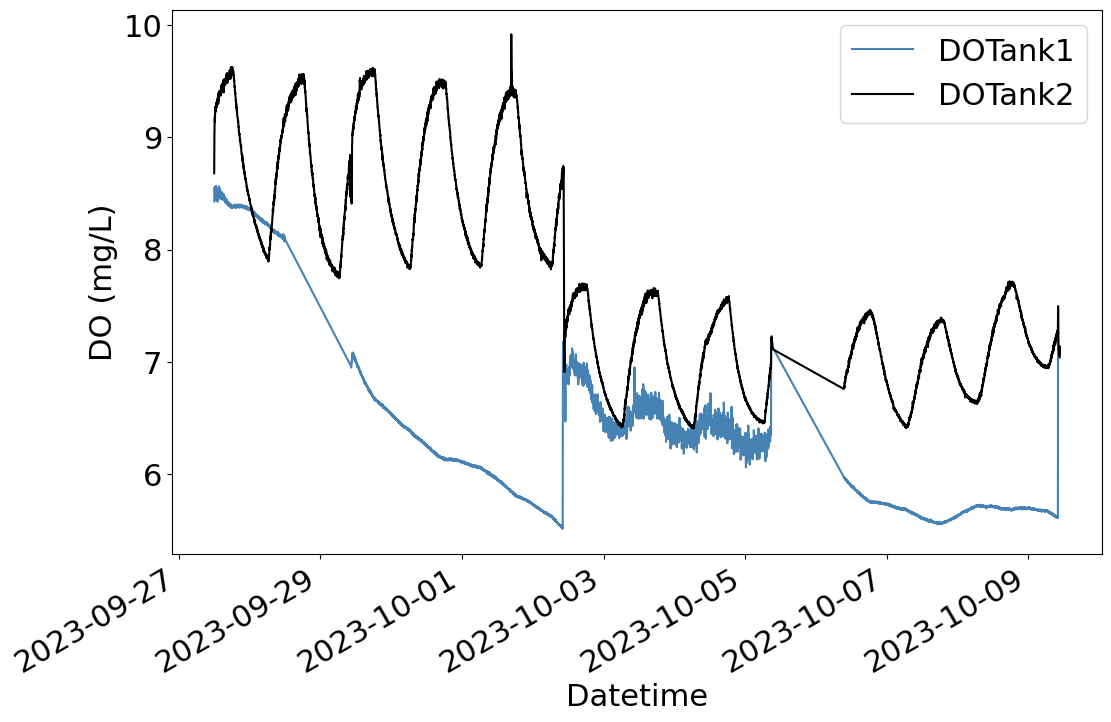

In [35]:
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(figsize = (12, 8))

ax1 = DO1.plot(ax=ax1, x='Datetime', y='DO..mg.l.',color="steelblue", label = 'DOTank1', figsize=(12,8))
DO2.plot(ax=ax1,x='Datetime', y='DO..mg.l.', color="black",  label = 'DOTank2', figsize=(12,8))
ax1.set_ylabel('DO (mg/L)')  
ax1.legend(loc = "best")

fig_fn = 'DO_'+filename
fig_file = os.path.join('Figures', fig_fn+'.png')
plt.savefig(fig_file, dpi = 500, transparent=False)